<a href="https://colab.research.google.com/github/Kathy42xu/UNdata_analysis/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd

excel_file = "/content/Task1_Analyze.xlsx"  # or your local path


# 1) Read the "Meta-POPLN" sheet to filter countries in East Asia & Pacific with "Lower middle income"
meta_df = pd.read_excel(excel_file, sheet_name="Meta-POPLN")


meta_filtered = meta_df[
    (meta_df["Region"] == "East Asia & Pacific") &
    (meta_df["IncomeGroup"] == "Lower middle income")
]

# 2) Read the "Data-POPLN" sheet to get the "Population, total" indicator and merge with meta_filtered

popln_df = pd.read_excel(excel_file, sheet_name="Data-POPLN")

popln_df = popln_df[popln_df["Indicator Name"] == "Population, total"]

# Merge with meta_filtered on "Country Code" to get only the countries matching the criteria
merged_popln = pd.merge(
    meta_filtered, popln_df,
    on="Country Code",
    how="inner"
)

# Extract the 2015 population from the "2015" column
merged_popln["Population_2015"] = merged_popln["2015"]


# 3) Select the top 10 countries based on the 2015 population
top10 = merged_popln.sort_values(by="Population_2015", ascending=False).head(10)


# 4) Read the "Data-HLTHEXPENDITURE" sheet and filter for the appropriate series

hlth_df = pd.read_excel(excel_file, sheet_name="Data-HLTHEXPNDITURE")

hlth_filtered = hlth_df[
    hlth_df["Series Name"] == "Domestic general government health expenditure (% of current health expenditure)"
].copy()

# 5) Merge top10 with the health expenditure data on "Country Code"
merged_hlth = pd.merge(
    top10,
    hlth_filtered,
    on="Country Code",
    how="inner",
    suffixes=("_popln", "_health")
)

# 6) Rename columns for years 2005 to 2015 from "2005 [YR2005]" to "Val_2005", etc.
years = range(2000, 2021)
for y in years:
    old_col = f"{y} [YR{y}]"
    new_col = f"Val_{y}"
    if old_col in merged_hlth.columns:
        merged_hlth.rename(columns={old_col: new_col}, inplace=True)


# 7) Calculate the year-over-year (YoY) percentage change for 2006–2015
#    YoY_year = (Val_year - Val_(year-1)) / Val_(year-1) * 100

for year in range(2006, 2016):
    cur_col = f"Val_{year}"
    prev_col = f"Val_{year - 1}"
    yoy_col = f"YoY_{year}"

    if cur_col in merged_hlth.columns and prev_col in merged_hlth.columns:
        # Calculate the YoY percentage change and force float type to enable rounding
        merged_hlth[yoy_col] = ((merged_hlth[cur_col].astype(float) - merged_hlth[prev_col].astype(float))
                                / merged_hlth[prev_col].astype(float) * 100).round(1)
    else:
        merged_hlth[yoy_col] = pd.NA


# 8) Create the final summary table: Country Name + YoY_2006 to YoY_2015
# Note: the country name from the population table is stored as "Country Name_popln"
output_cols = ["Country Name_popln"] + [f"YoY_{y}" for y in range(2006, 2016)]
summary_df = merged_hlth[output_cols].copy()
summary_df.rename(columns={"Country Name_popln": "Country Name"}, inplace=True)

summary_df.sort_values(by="Country Name", inplace=True)

print("\nAnnual Increase in Domestic General Government Health Expenditure (YoY %) "
      "for the Ten Most-Populated Lower Middle Income Countries in East Asia & Pacific\n"
      "Period: 2005–2015 (YoY from 2006–2015)\n")
print(summary_df.to_string(index=False))

# Save the final summary table to Excel
summary_df.to_excel("health_yoy_summary.xlsx", index=False)



Annual Increase in Domestic General Government Health Expenditure (YoY %) for the Ten Most-Populated Lower Middle Income Countries in East Asia & Pacific
Period: 2005–2015 (YoY from 2006–2015)

    Country Name  YoY_2006  YoY_2007  YoY_2008  YoY_2009  YoY_2010  YoY_2011  YoY_2012  YoY_2013  YoY_2014  YoY_2015
        Cambodia     -12.0      26.3     -21.6       3.4      22.8     -13.6      13.6       3.1      -7.4      17.3
       Indonesia       9.7      13.7      -2.3      -0.3     -32.6      -0.9      12.1       8.1      17.6      18.2
         Lao PDR     -19.4     -17.4       2.6      78.5     -37.4      -9.0      11.5      41.2       0.2      18.4
        Mongolia       9.8       6.4      -0.1      -1.5      -6.0      -9.1       2.2      -8.1       2.3      -0.4
         Myanmar      63.9     -15.9     -19.3       6.9      13.6      21.5      44.0       9.6      28.1      -9.1
Papua New Guinea       1.9       0.5       5.0      -5.7      -7.7       5.8       4.7      -3.1      -

An AI generated notebook created with [Data Science Agent](https://labs.google.com/code/dsa) from Google Labs 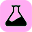
